# Similitud vectorial por medio de analisis de texto por Transformer

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

### base de datos 

In [7]:
ruta_carpeta = "E://Maestria/2023-2/Temas/datos_proyecto/archive/test_file.csv"
df2 = pd.read_csv(ruta_carpeta) 
df2=df2.head(300)
display(df2)

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0
...,...,...,...,...,...,...,...,...,...
295,iwml5iqGfg,Lenovo ThinkPad X1 Yoga review,Key Specifications HD webcam Yes Touchscreen Y...,Digital Trends via Yahoo! Finance,microsoft,2016-03-29 17:28:00,0,0,0
296,khOoYQDLyc,Lenovo ThinkPad X1 Yoga review,Key Specifications HD webcam Yes Touchscreen Y...,Digital Trends via Yahoo! Sports,microsoft,2016-03-29 17:28:00,0,0,0
297,7ijbPSYCGW,China's future challenge for the world economy,China's attempted economic transition has deep...,Financial Times,economy,2016-03-29 17:32:09,50,7,140
298,hCgKLYy9BG,Canadian UN human rights adviser for Palestine...,A Canadian legal scholar appointed as the Unit...,Ottawa Sun,palestine,2016-03-29 17:34:00,0,0,0


In [8]:
df2.value_counts('Topic')

Topic
economy      107
obama         98
microsoft     57
palestine     38
dtype: int64

### Transformer

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Cargar modelo preentrenado y tokenizador (reemplazar 'bert-base-uncased' con el modelo que desees)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Tokenizar tweets y calcular embeddings
encoded_inputs = tokenizer(list(df2['Title']), padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_inputs)

# Realizar Mean Pooling para obtener las representaciones vectoriales de los tweets
tweet_embeddings = mean_pooling(model_output, encoded_inputs['attention_mask'])

# Aplicar k-means para agrupar los tweets
num_clusters = 4  # Número de clusters deseado
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tweet_embeddings)

# Agregar la información de los clusters a los datos originales
df2['cluster'] = clusters

# Imprimir los resultados
print("Resultados del Agrupamiento:")
print(df2[['Title', 'cluster']])

Resultados del Agrupamiento:
                                                 Title  cluster
0    Sliding Economy: FG fights back with N3trn TSA...        2
1    Microsoft shows how HoloLens can bring distant...        2
2    Microsoft’s Twitter Robot Praises Hitler, Trum...        3
3    Flood of Central Bank Moves Can't Get World Ec...        1
4    USD/JPY: bears lining up on mixed U.S. economy...        1
..                                                 ...      ...
295                     Lenovo ThinkPad X1 Yoga review        2
296                     Lenovo ThinkPad X1 Yoga review        2
297     China's future challenge for the world economy        1
298  Canadian UN human rights adviser for Palestine...        0
299  Obama Gifted With Restored Copy of 'Native Son...        3

[300 rows x 2 columns]


C:\Users\user\anaconda3\envs\Redesneuronales\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\envs\Redesneuronales\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [18]:
df2.value_counts('cluster')

cluster
3    101
0     83
2     59
1     57
dtype: int64

In [20]:
df2.value_counts('Topic')

Topic
economy      107
obama         98
microsoft     57
palestine     38
dtype: int64

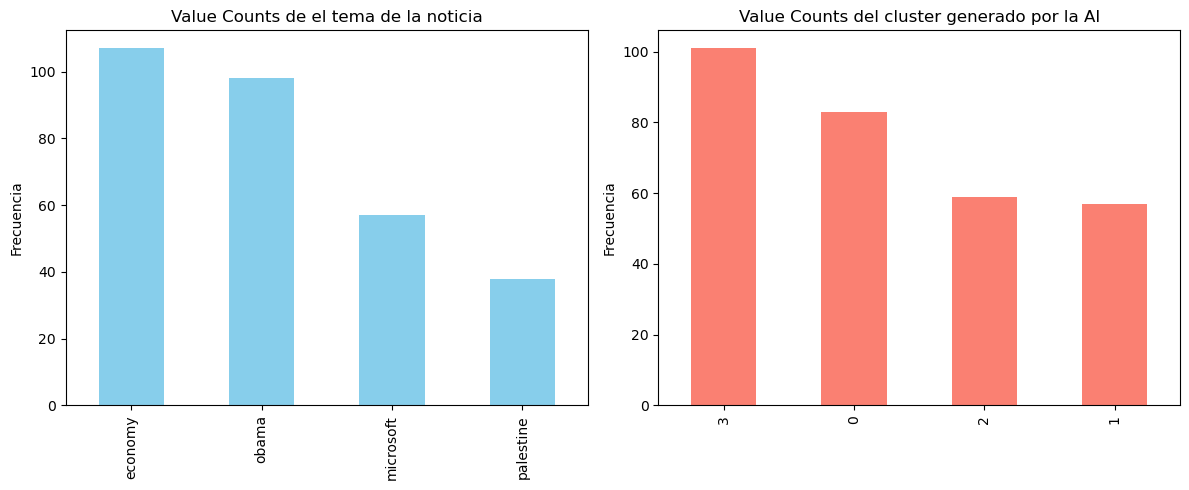

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Graficar value counts de "Topic"
df2['Topic'].value_counts().plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Value Counts de el tema de la noticia')
#axs[0].set_xlabel('Valores')
axs[0].set_ylabel('Frecuencia')

# Graficar value counts de "cluster"
df2['cluster'].value_counts().plot(kind='bar', color='salmon', ax=axs[1])
axs[1].set_title('Value Counts del cluster generado por la AI')
#axs[1].set_xlabel('Valores')
axs[1].set_ylabel('Frecuencia')

# Ajustar el diseño
plt.tight_layout()
plt.show()
